In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils.models import LSTM



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/
!rmdir  /S /Q "../workfiles/logs/"

'rm' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
Le fichier sp�cifi� est introuvable.


In [2]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

absolute_path = "c:/thesis/data/quant"
metadata_path = "c:/thesis/METADATA_200123.xlsx"

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    path = absolute_path,
    metadata_path = metadata_path,
    retain_phases = "Both",
    feature_selection_threshold = 10, 
    batch_size= 32,
    normalization = True,
    transpose=True,
    as_time_series = True,
    MT_removal = True,
    log1p = True)

Retaining patients that are included in phases 1 & 2
retaining all patient who have passed all visits...
loading samples...
loaded 1455 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  10 ...
number of genes selected :  2919
normalizing data...
normalization done
number of seq in the dataset : 1455
converting samples to time series
number of actual individual to be studied : 291
using transposed data...


In [3]:
importlib.reload(LSTM) # to allow modification of the script without restarting the whole session

latent_dim = 32
sequence_length = 5

t_shape = (sequence_length, n_genes)

# SINCE WE USE TRANSPOSE :
t_shape = (n_genes, sequence_length)


autoencoder = LSTM.generate_model(t_shape, latent_dim, True)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [8]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=50, min_lr=0.000001)


early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=75)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, 
      reduce_lr, 
      #early_stopping_callback, 
      tensorboard_callback]

In [6]:
#%tensorboard --logdir ../workfiles/logs/fit

4k ish

12K for 512 + 256


very unstable training on small batch size



In [9]:
hist = autoencoder.fit(x_train, epochs=5000, callbacks=cb)

Epoch 1/5000
10/10 [==============================] - 26s 1s/step - loss: 3.4551e-04 - lr: 0.0010
Epoch 2/5000
10/10 [==============================] - 13s 1s/step - loss: 2.5666e-04 - lr: 0.0010
Epoch 3/5000
10/10 [==============================] - 12s 1s/step - loss: 2.5280e-04 - lr: 0.0010
Epoch 4/5000
10/10 [==============================] - 11s 1s/step - loss: 2.4968e-04 - lr: 0.0010
Epoch 5/5000
10/10 [==============================] - 12s 1s/step - loss: 2.4134e-04 - lr: 0.0010
Epoch 6/5000
10/10 [==============================] - 12s 1s/step - loss: 2.4117e-04 - lr: 0.0010
Epoch 7/5000
10/10 [==============================] - 12s 1s/step - loss: 2.3961e-04 - lr: 0.0010
Epoch 8/5000
10/10 [==============================] - 12s 1s/step - loss: 2.3951e-04 - lr: 0.0010
Epoch 9/5000
10/10 [==============================] - 12s 1s/step - loss: 2.3913e-04 - lr: 0.0010
Epoch 10/5000
10/10 [==============================] - 12s 1s/step - loss: 2.3916e-04 - lr: 0.0010
Epoch 11/5000
10/10

10/10 [==============================] - 10s 960ms/step - loss: 8.2001e-04 - lr: 1.0000e-05


In [10]:
autoencoder.load_weights(checkpoint_filepath)


[0.00030930456705391407, 0.00025413974071852863, 0.0002505423326510936, 0.0002476123918313533, 0.00024030373606365174, 0.00023998355027288198, 0.00023882965615484864, 0.00023876430350355804, 0.00023846226395107806, 0.00023843646340537816, 0.0002384420222369954, 0.0002402593963779509, 0.00023932510521262884, 0.00023923913249745965, 0.00023837735352572054, 0.00023789719853084534, 0.00023776243324391544, 0.00023772657732479274, 0.00023774955479893833, 0.00023831606085877866, 0.00023882644018158317, 0.00023917629732750356, 0.00023855101608205587, 0.0002388042921666056, 0.00023839218192733824, 0.00023797043832018971, 0.00023764949582982808, 0.0002373513561906293, 0.00023741422046441585, 0.00023739354219287634, 0.00023850586148910224, 0.00023820098431315273, 0.0002383029059274122, 0.00023792142746970057, 0.00023748836247250438, 0.00023737519222777337, 0.00023771257838234305, 0.00023770924599375576, 0.00023769335530232638, 0.00023742680787108839, 0.00023706066713202745, 0.00023722363403066993

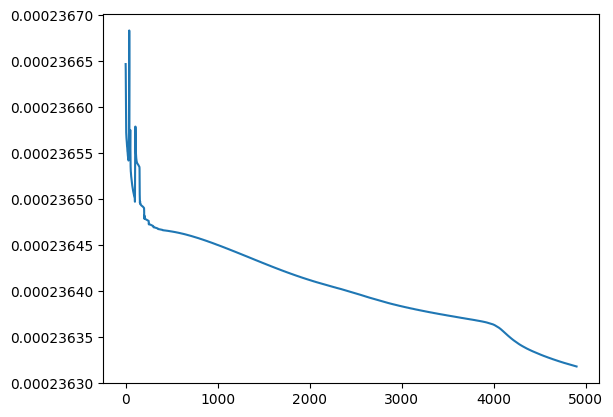

In [11]:
plt.plot(hist.history['loss'][100:])
print(hist.history['loss'])

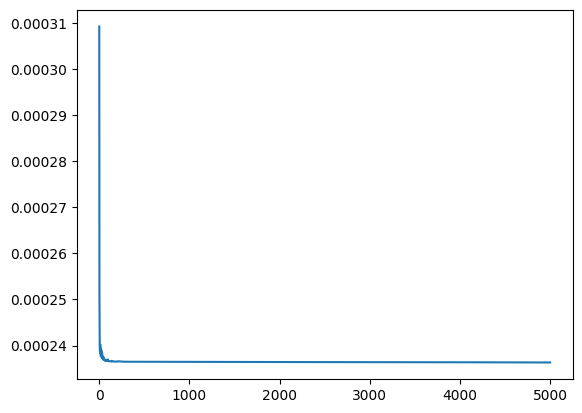

In [12]:
plt.plot(hist.history['loss'])


### some diagnosis

In [13]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
decoded = autoencoder.decoder(z)

In [14]:
e_ = e[0]  
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0]  



# Create subplot grid with vertical stacking
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=e_, colorscale='viridis')
fig.add_trace(heatmap_trace1, row=1, col=1)

# Add the latent representation as a heatmap-like plot
tensor_reshaped = z.reshape(1, -1)
heatmap_trace2 = go.Heatmap(z=z_, colorscale='viridis')
fig.add_trace(heatmap_trace2, row=2, col=1)

# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=decoded_, colorscale='viridis')
fig.add_trace(heatmap_trace3, row=3, col=1)

# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)

# Update x-axis labels
#fig.update_xaxes(title_text='genes (normalized)', row=1, col=1)
#fig.update_xaxes(title_text='latent representation', row=2, col=1)
#fig.update_xaxes(title_text='genes (normalized)', row=3, col=1)

# Update y-axis labels
#fig.update_yaxes(title_text='timestamps', row=1, col=1)
#fig.update_yaxes(title_text='latent representation', row=2, col=1)
#fig.update_yaxes(title_text='timestamps', row=3, col=1)

fig.show()

In [22]:
autoencoder.encoder.save('../workfiles/T_LSTM')


INFO:tensorflow:Assets written to: ../workfiles/T_LSTM\assets


INFO:tensorflow:Assets written to: ../workfiles/T_LSTM\assets


In [15]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

10/10 [==============================] - 4s 284ms/step


In [16]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [19]:
df.to_csv("../workfiles/processed_data_t_lstm.csv", index=False)


# Viz

In [17]:
import seaborn as sns

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



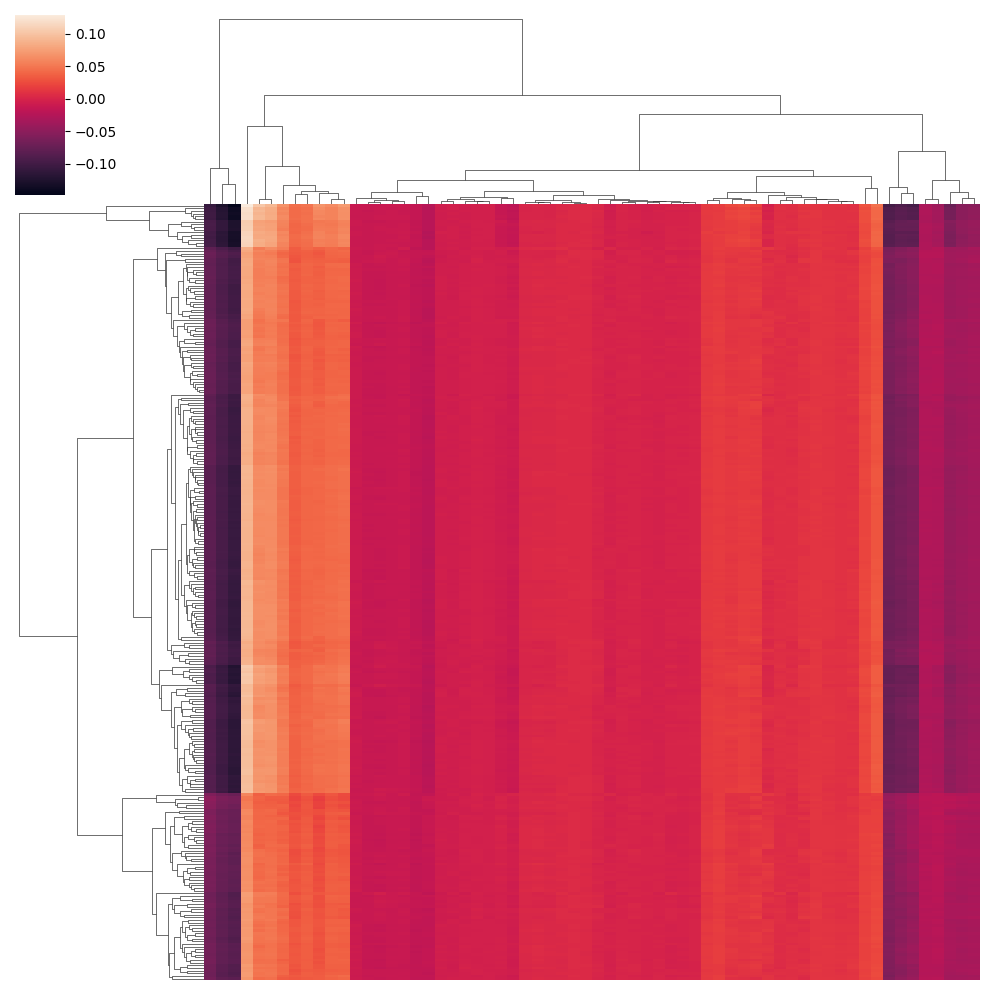

In [18]:
cluster_plot = sns.clustermap(compressed_dataframe,yticklabels=False,xticklabels=False)
cluster_plot

In [25]:
# let's reconstruct the dataset 
decoded = autoencoder.decoder.predict(compressed_dataframe)
print(decoded.shape)
# and flatten it
decoded = decoded.reshape(decoded.shape[0], decoded.shape[1]*decoded.shape[2])


10/10 [==============================] - 2s 196ms/step
(291, 2919, 5)


C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

C:\Users\Alain\AppData\Roaming\Python\Python39\site-packages\seaborn\matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



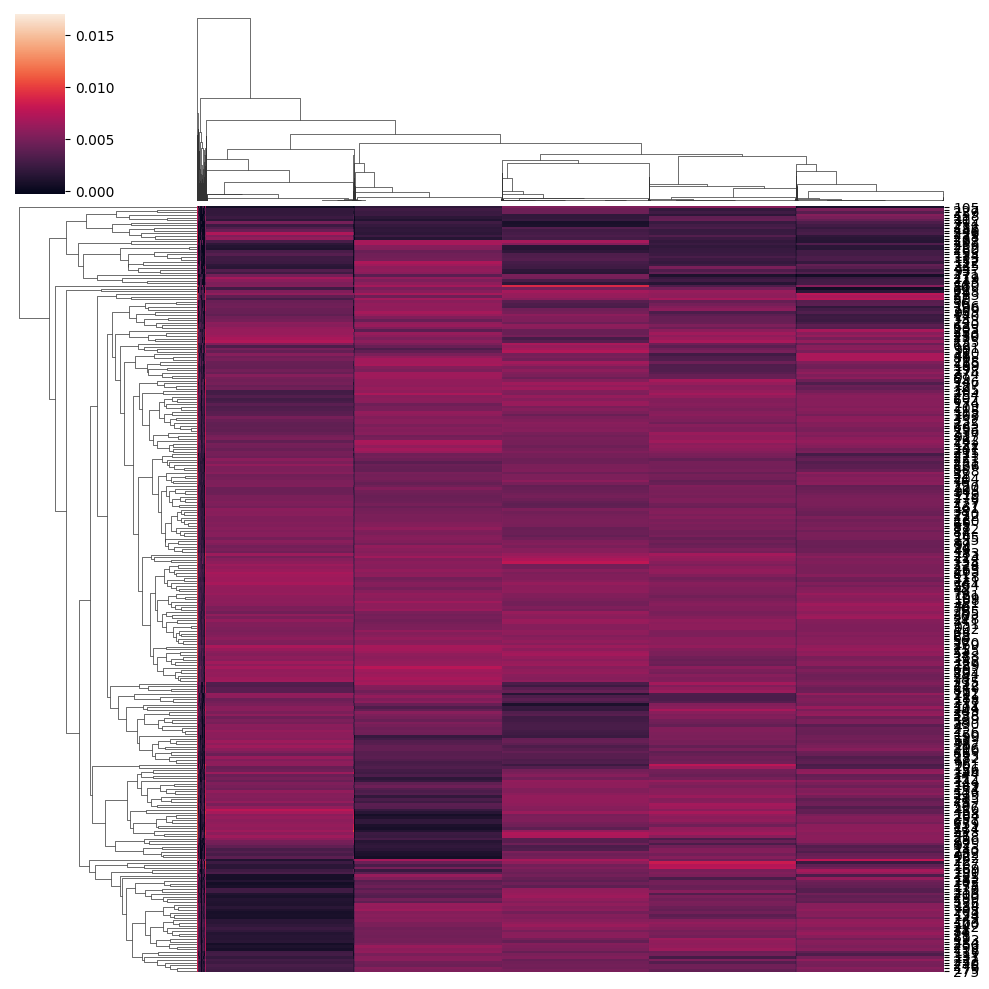

In [26]:
cluster_plot = sns.clustermap(decoded,yticklabels=True,xticklabels=False)
cluster_plot